In [9]:
# import modules from other folders
# source: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook
# author: adhg (accessed 15 June 2025)
import os
import sys

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'src/python'))
# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

from train_logistic_model import *
from lexicon import create_lexicon
import config as cfg

In [2]:
# computationally expensive
# prefer loading dataset when possibile

try:
    df_train = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_train.csv")
    df_val = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_val.csv")
    df_test = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_test.csv")
except FileNotFoundError:
    df_train, df_val, df_test = create_data_splits_with_kb_features(merge_train_test())

#### Train baseline model

In [ ]:
# generate lexicon on train data
create_lexicon(df_train)

In [3]:
X_train, y_train = split_feature_target(df_train, "label")
X_val, y_val = split_feature_target(df_val, "label")

In [4]:
pipeline = create_pipeline()
pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('kbnum', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Valuate baseline model

In [5]:
y_val_pred = pipeline.predict(X_val)
y_val_proba = pipeline.predict_proba(X_val)[:,1]

Acc val: 0.8929
AUC val: 0.9597508000000001
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Acc val: 0.8929
AUC val: 0.9597508000000001
LogLoss: 0.2811467789915403
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



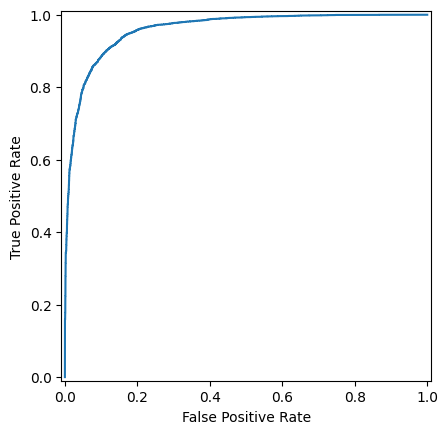

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

print("Acc val:", accuracy_score(y_val, y_val_pred))
print("AUC val:", roc_auc_score(y_val, y_val_proba))
print("LogLoss:", log_loss(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [18]:
import joblib
joblib.dump(pipeline, "../models/baseline.pkl")

['../models/baseline.pkl']

#### Cross-Validation

In [19]:
param_grid = {
    # TF-IDF
    "pre__tfidf__ngram_range": [(1,1),(1,2)],
    "pre__tfidf__min_df": [5],
    "pre__tfidf__max_df": [0.9],
    # Classificatore
    "clf__C": [0.1, 1, 10]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,               
    scoring="roc_auc",   
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best = grid.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 10, 'pre__tfidf__max_df': 0.9, 'pre__tfidf__min_df': 5, 'pre__tfidf__ngram_range': (1, 2)}
Best CV AUC: 0.9561259066666667


In [21]:
y_val_pred = best.predict(X_val)
y_val_proba = best.predict_proba(X_val)[:,1]

Acc val: 0.8911
AUC val: 0.9586534
LogLoss: 0.26167141256720633
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



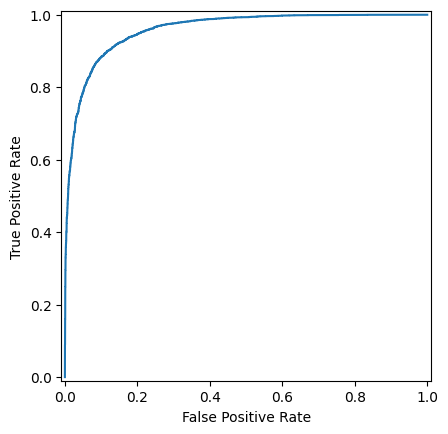

In [22]:
print("Acc val:", accuracy_score(y_val, y_val_pred))
print("AUC val:", roc_auc_score(y_val, y_val_proba))
print("LogLoss:", log_loss(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [20]:
joblib.dump(best, "../models/best.pkl")

['../models/best.pkl']

#### Test Set

In [23]:
# train the model on both train and validation
df_train_val = pd.concat([df_train, df_val], ignore_index=True)

In [24]:
create_lexicon(df_train_val)

In [25]:
best_params = grid.best_params_
X_train_val, y_train_val = split_feature_target(df_train_val, "label")

final_pipeline = create_pipeline().set_params(**best_params)
final_pipeline.fit(X_train_val, y_train_val)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('kbnum', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [79]:
# valuate on test set
X_test, y_test = split_feature_target(df_test, "label")
%time y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

CPU times: total: 5min 24s
Wall time: 5min 25s


Acc val: 0.8995
AUC val: 0.9637908399999999
LogLoss: 0.245416453215184
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5000
           1       0.90      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



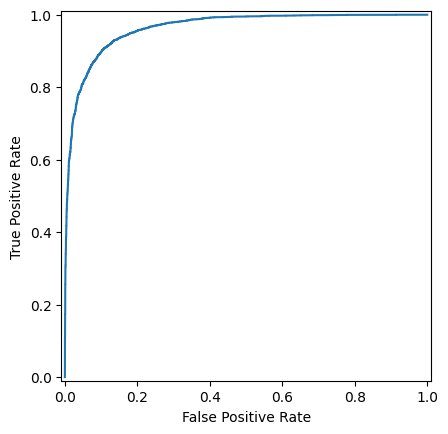

In [27]:
print("Acc val:", accuracy_score(y_test, y_pred))
print("AUC val:", roc_auc_score(y_test, y_proba))
print("LogLoss:", log_loss(y_test, y_proba))
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [28]:
joblib.dump(final_pipeline, "../models/final.pkl")

['../models/final.pkl']

#### Compare only KB model and only TFD-IDF model 

In [29]:
# generate lexicon on train data
create_lexicon(df_train)

In [32]:
# create only KB pipeline
kb_preprocessor = ColumnTransformer(transformers=[
    ("kbnum", StandardScaler(), ["sentiment_sum", "avg_nonzero", "ratio"])
], remainder="drop")

kb_pipeline = Pipeline([
    ("pre", kb_preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# train pipeline
kb_pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('kbnum', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
# compute metrics
y_val_pred = kb_pipeline.predict(X_val)
y_val_proba = kb_pipeline.predict_proba(X_val)[:,1]

Acc val: 0.6855
AUC val: 0.7532050000000001
LogLoss: 0.5888985264621668
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      5000
           1       0.69      0.68      0.68      5000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



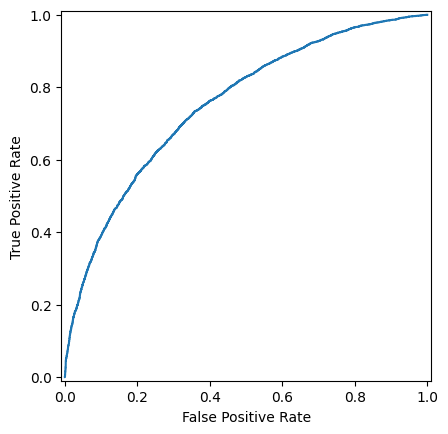

In [34]:
print("Acc val:", accuracy_score(y_val, y_val_pred))
print("AUC val:", roc_auc_score(y_val, y_val_proba))
print("LogLoss:", log_loss(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [36]:
# create only TF-IDF pipeline
vectorizer = TfidfVectorizer(
    tokenizer=normalized_tokenizer,
    preprocessor=None,
    lowercase=False,
    token_pattern=None,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=10000,
    sublinear_tf=True
)

tf_idf_preprocessor = ColumnTransformer(transformers=[
    ("tfidf", vectorizer, "text"),
], remainder="drop")

tf_idf_pipeline = Pipeline([
    ("pre", tf_idf_preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# train pipeline
tf_idf_pipeline.fit(X_train, y_train)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
# compute metrics
y_val_pred = tf_idf_pipeline.predict(X_val)
y_val_proba = tf_idf_pipeline.predict_proba(X_val)[:,1]

Acc val: 0.8963
AUC val: 0.9616990000000001
LogLoss: 0.283430585858576
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



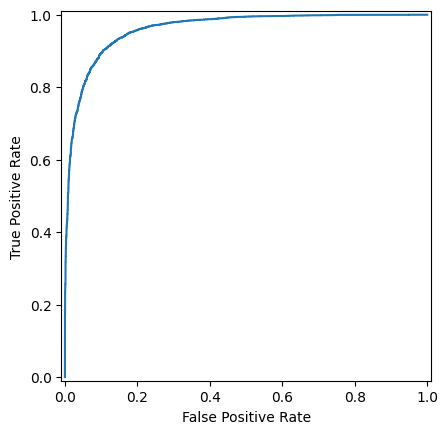

In [38]:
print("Acc val:", accuracy_score(y_val, y_val_pred))
print("AUC val:", roc_auc_score(y_val, y_val_proba))
print("LogLoss:", log_loss(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Data Driven Lexicon

In [14]:
import joblib
model = joblib.load("../models/best.pkl")

In [30]:
import numpy as np

# Retrieve vectorizer
vectorizer = model.named_steps["pre"].named_transformers_["tfidf"]
feature_names = vectorizer.get_feature_names_out()

# Obtain coefficients
coef = model.named_steps["clf"].coef_[0]

# Exclude bigrams
uni_idx = [i for i, term in enumerate(feature_names) if " " not in term]
uni_terms = feature_names[uni_idx]
uni_coefs = coef[uni_idx]

# Visualize important terms
top_pos = np.argsort(uni_coefs)[-20:][::-1]
top_neg = np.argsort(uni_coefs)[:20]

print("Top Positive unigrams:")
for j in top_pos:
    print(uni_terms[j], uni_coefs[j])
print("\nTop Negative unigrams:")
for j in top_neg:
    print(uni_terms[j], uni_coefs[j])

Top Positive unigrams:
great 10.082093364127925
hilarious 8.539830659286576
today 8.268011900556168
excellent 7.798372786556767
not_excellent 7.7206747247648355
fun 7.577929053574951
wonderful 7.012345694852334
amazing 6.881041417977477
refreshing 6.844473468251658
funny 6.53413013096795
perfect 6.15843992430666
realistic 6.121166630435784
enjoyable 6.1191249048934235
stunning 6.105656370636463
fantastic 6.078516935194245
not_disappoint 6.0356866769366
highly 6.02636433794183
not_perfect 5.988136788431565
worth 5.8761866898444
delightful 5.855494130110355

Top Negative unigrams:
awful -12.439836530466046
not_bad -11.599610963677229
boring -10.912583229236878
dull -10.63445816401177
waste -10.594077127517757
bad -10.105018373346693
poor -8.845014134868904
disappointing -8.57501619366111
laughable -8.332521867567095
lame -7.813813645562454
disappointed -7.686195539212533
ridiculous -7.645933435094718
lack -7.453645985559555
not_awful -7.436547354808065
disappointment -7.112346179971262
n

In [45]:
# normalize scores
max_abs = np.max(np.abs(uni_coefs))

lexicon_scores = {}
for term, coef in zip(uni_terms, uni_coefs):
    score = float(coef / max_abs)  # normalize to range [-1, 1]
    lexicon_scores[term] = score

# create lexicon
with open(cfg.LEXICON_PATH, "w", encoding="utf-8") as f:
    for term, score in lexicon_scores.items():
        f.write(f'word_score("{term}", {score}).\n')

    # write intensifiers
    f.write('\n% Intensifiers\n')
    for intensifier in cfg.INTENSIFIERS:
        f.write(f'intensifier("{intensifier}", {cfg.INTENSIFIERS[intensifier]}).\n')
    
    # write negators
    f.write('\n% Negators\n')
    for negator in cfg.NEGATORS:
        f.write(f'negator("{negator}").\n')

In [47]:
# process datasets
features = ["text", "label"]
df_train_lex = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_train.csv")[features]
df_val_lex = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_val.csv")[features]

from sklearn.model_selection import train_test_split

X_val = df_val_lex[["text"]]
y_val = df_val_lex["label"]

In [48]:
# create a new validation set with features extracted from the KB
X_val = extract_features(X_val, False)

In [49]:
# define function for plotting
# written by ChatGPT

import matplotlib.pyplot as plt

def plot_histogram_metric(df, metric, label_col='label', bins=30):
    """
    Disegna due istogrammi sovrapposti di 'metric' per le due classi indicate in label_col (0 e 1).
    df: DataFrame con almeno le colonne metric e label_col.
    metric: nome della colonna numerica da visualizzare.
    label_col: nome della colonna con valori 0/1 (o equivalenti).
    bins: numero di bin per l'istogramma.
    """
    # Estrai valori per ciascuna classe
    vals_pos = df[df[label_col] == 1][metric].dropna()
    vals_neg = df[df[label_col] == 0][metric].dropna()
    plt.figure()
    plt.hist(vals_pos, bins=bins, alpha=0.6, label='Positive')
    plt.hist(vals_neg, bins=bins, alpha=0.6, label='Negative')
    plt.xlabel(metric)
    plt.ylabel('Count')
    plt.title(f'Distribution of {metric} by label')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

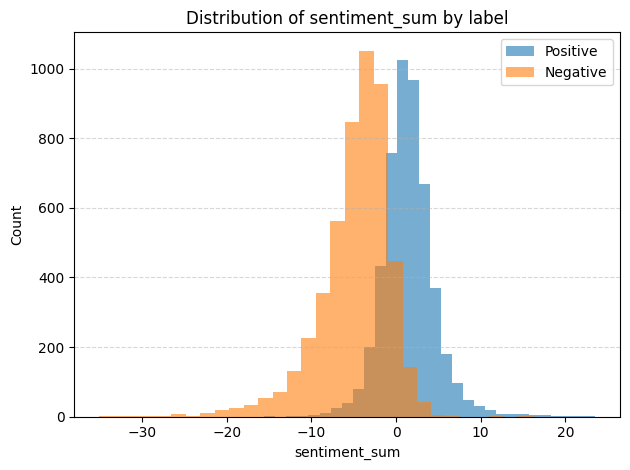

In [70]:
Xv = X_val.reset_index(drop=True)
yv = y_val.reset_index(drop=True).to_frame(name="label")
plot_histogram_metric(pd.concat([Xv, yv], axis=1), "sentiment_sum")

In [69]:
pd.concat([Xv, yv], axis=1).groupby("label")["sentiment_sum"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5000.0,-4.841254,4.224096,-35.082694,-6.750230,-4.141852,-2.101787,16.140537
1,5000.0,1.423871,3.150074,-15.559290,-0.358827,1.289305,2.995143,23.538771


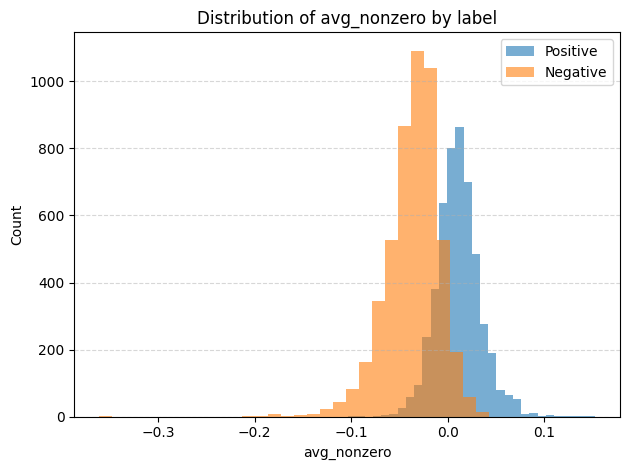

In [71]:
plot_histogram_metric(pd.concat([Xv, yv], axis=1), "avg_nonzero")

In [72]:
pd.concat([Xv, yv], axis=1).groupby("label")["avg_nonzero"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5000.0,-0.035467,0.028076,-0.361287,-0.050454,-0.032097,-0.017201,0.043316
1,5000.0,0.011245,0.022890,-0.102945,-0.002937,0.010370,0.023959,0.153040


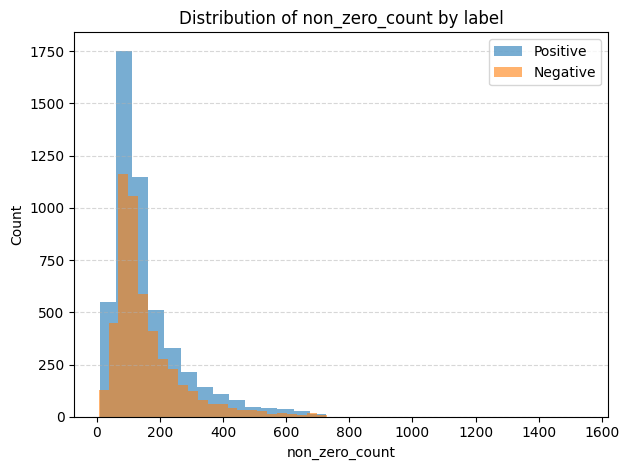

In [68]:
plot_histogram_metric(pd.concat([Xv, yv], axis=1), "non_zero_count")

In [73]:
pd.concat([Xv, yv], axis=1).groupby("label")["non_zero_count"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5000.0,158.6464,113.855921,6.0,89.0,122.0,190.0,948.0
1,5000.0,158.9434,120.268805,10.0,87.0,119.0,192.0,1543.0


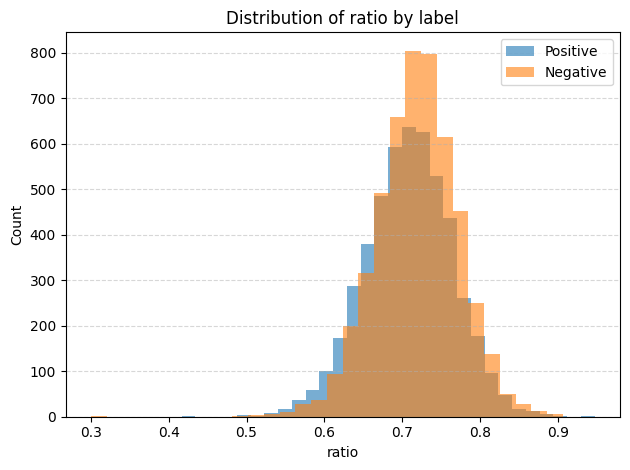

In [74]:
plot_histogram_metric(pd.concat([Xv, yv], axis=1), "ratio")

In [75]:
pd.concat([Xv, yv], axis=1).groupby("label")["ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5000.0,0.719520,0.052706,0.300000,0.686797,0.720833,0.753334,0.906250
1,5000.0,0.707961,0.056512,0.416667,0.671233,0.709451,0.746154,0.947368


In [52]:
# define functions
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_ROC(y_true, feature, calculate_optimal=False):
    fpr, tpr, thresholds = roc_curve(y_true, feature)
    auc_score = roc_auc_score(y_true, feature)

    plt.figure(figsize=(7, 6))

    # calculate optimal threshold
    if calculate_optimal:
        j_scores = tpr - fpr  # Youden's J statistic
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=80,
                    label=f'Optimal Threshold: {optimal_threshold:.3f}')
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if calculate_optimal:
        return optimal_threshold

def evaluate_thresholds(num_thresholds=100):
    # convert to numpy array
    feat = np.asarray(X_val["sentiment_sum"])
    lab = np.asarray(y_val)
    
    # define thresholds
    min_val, max_val = np.min(feat), np.max(feat)
    thresholds = np.linspace(min_val, max_val, num_thresholds)

    # evaluate
    results = []
    for thr in thresholds:
        y_pred = [1 if sentiment >= thr else 0 for sentiment in X_val["sentiment_sum"]]
        
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)

        results.append({
                'threshold': thr,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
        })

    df_metrics = pd.DataFrame(results)

    return df_metrics

def plot_metrics_vs_threshold(df_metrics, optimal_threshold=None):
    plt.figure(figsize=(8, 6))
    for col in ['accuracy', 'precision', 'recall']:
        plt.plot(df_metrics['threshold'], df_metrics[col], label=col)

    if optimal_threshold is not None:
        plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'optimal threshold : {optimal_threshold:.3f}')

    plt.xlabel('Threshold')
    plt.ylabel('Valore metrica')
    plt.title('Metriche vs Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

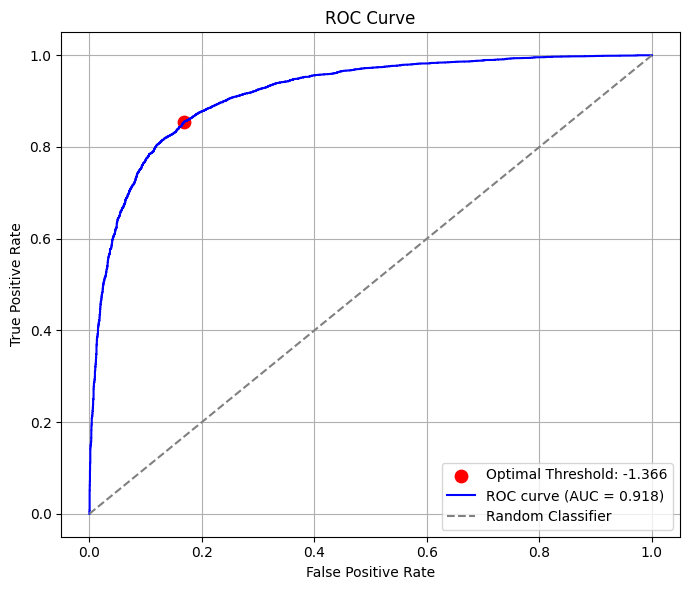

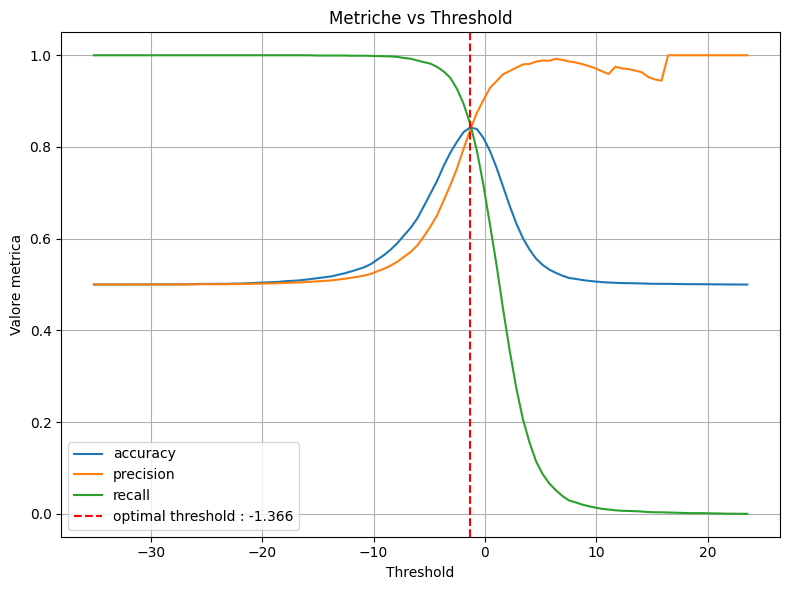

Optimal threshold: -1.366
Accuracy for optimal threshold: 0.843
Precision for optimal threshold: 0.836
Recall for optimal threshold: 0.855


In [53]:
optimal_threshold = plot_ROC(y_val, X_val["sentiment_sum"], True)
plot_metrics_vs_threshold(evaluate_thresholds(), optimal_threshold)

# print metrics for optimal threshold
y_pred = [1 if sentiment >= optimal_threshold else 0 for sentiment in X_val["sentiment_sum"]]
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)

print(f'Optimal threshold: {optimal_threshold:.3f}')
print(f'Accuracy for optimal threshold: {accuracy:.3f}')
print(f'Precision for optimal threshold: {precision:.3f}')
print(f'Recall for optimal threshold: {recall:.3f}')

#### Test against the test set

In [54]:
final = joblib.load("../models/final.pkl")

In [55]:
# Retrieve vectorizer
vectorizer = final.named_steps["pre"].named_transformers_["tfidf"]
feature_names = vectorizer.get_feature_names_out()

# Obtain coefficients
coef = final.named_steps["clf"].coef_[0]

# Exclude bigrams
uni_idx = [i for i, term in enumerate(feature_names) if " " not in term]
uni_terms = feature_names[uni_idx]
uni_coefs = coef[uni_idx]

# Visualize important terms
top_pos = np.argsort(uni_coefs)[-20:][::-1]
top_neg = np.argsort(uni_coefs)[:20]

print("Top Positive unigrams:")
for j in top_pos:
    print(uni_terms[j], uni_coefs[j])
print("\nTop Negative unigrams:")
for j in top_neg:
    print(uni_terms[j], uni_coefs[j])

Top Positive unigrams:
great 10.951472783018405
hilarious 9.912483876669562
today 8.515785632381881
excellent 8.37993317146343
wonderful 8.131979179257204
amazing 8.107572860861607
perfect 7.9402847663327565
fun 7.517367818218159
not_perfect 7.3604616759452774
enjoyable 7.23486051107639
refreshing 7.142332673078446
realistic 7.064715739099795
not_excellent 6.942101889468009
brilliant 6.681454200376709
superb 6.608750528220518
subtle 6.402485284547834
solid 6.34430210392018
underrated 6.332063393251826
powerful 6.326824323658957
gem 6.313609756487129

Top Negative unigrams:
awful -14.613372788683513
dull -12.766003269690552
not_bad -12.639207856260105
boring -12.58356269217967
waste -11.707301961631144
bad -11.413755667746576
laughable -10.161360902963235
disappointing -10.016941867824851
disappointed -9.582895882093005
lame -9.549163925096845
poor -9.142977380436799
disappointment -8.771627839069486
forgettable -8.403901180265612
lack -8.314580398323999
horrible -8.259715714069761
ridi

In [56]:
# normalize scores
max_abs = np.max(np.abs(uni_coefs))

lexicon_scores = {}
for term, coef in zip(uni_terms, uni_coefs):
    score = float(coef / max_abs)  # normalize to range [-1, 1]
    lexicon_scores[term] = score

# create lexicon
with open(cfg.LEXICON_PATH, "w", encoding="utf-8") as f:
    for term, score in lexicon_scores.items():
        f.write(f'word_score("{term}", {score}).\n')

    # write intensifiers
    f.write('\n% Intensifiers\n')
    for intensifier in cfg.INTENSIFIERS:
        f.write(f'intensifier("{intensifier}", {cfg.INTENSIFIERS[intensifier]}).\n')
    
    # write negators
    f.write('\n% Negators\n')
    for negator in cfg.NEGATORS:
        f.write(f'negator("{negator}").\n')

In [59]:
features = ["text", "label"]
df_test_lex = pd.read_csv(cfg.DATAFRAME_SAVE_PATH / "df_test.csv")[features]

In [61]:
# create a new validation set with features extracted from the KB
df_test_lex = extract_features(df_test_lex, False)

CPU times: total: 0 ns
Wall time: 2 ms


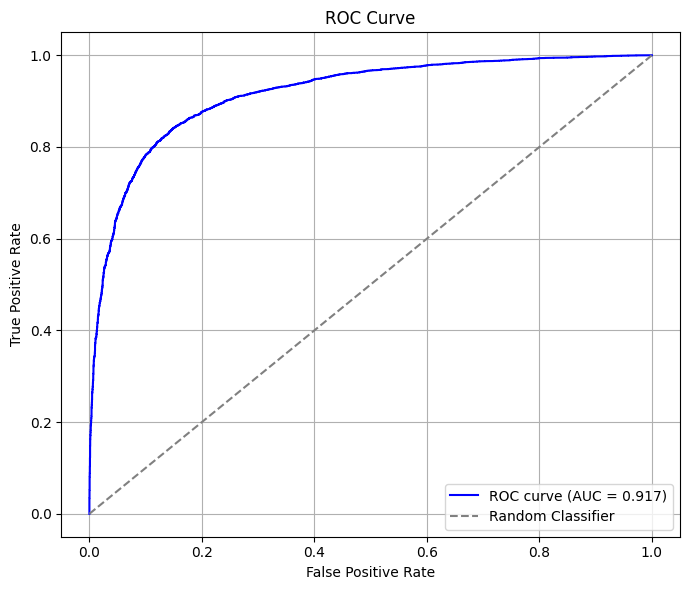

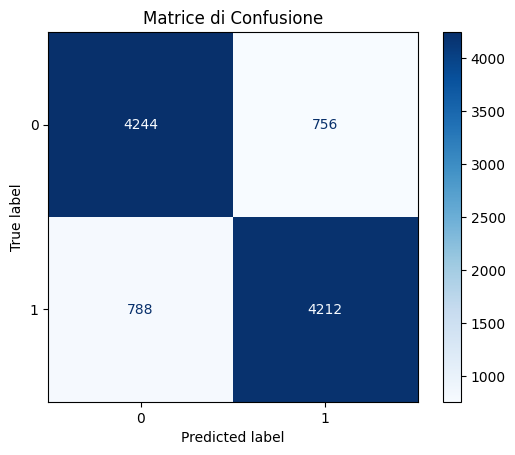

Accuracy: 0.846
Precision: 0.848
Recall: 0.842


In [76]:
# predict class
%time y_pred = [1 if sentiment >= optimal_threshold else 0 for sentiment in df_test_lex["sentiment_sum"]]

# calculate error metrics
accuracy = accuracy_score(df_test_lex["label"], y_pred)
precision = precision_score(df_test_lex["label"], y_pred, zero_division=0)
recall = recall_score(df_test_lex["label"], y_pred, zero_division=0)
cm = confusion_matrix(df_test_lex["label"], y_pred)

# print metrics, confusion matrix and plot ROC
plot_ROC(df_test_lex["label"], df_test_lex["sentiment_sum"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matrice di Confusione")
plt.show()

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')